This code generates timestream template for AFG1022 that gives frequency comb for calibration, mostly following Gadi's legacy Matlab code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import welch

In [2]:
def get_signal(tt, ff, phase=None):
    sig = np.zeros_like(tt)
    if phase is None:
        phase = np.zeros_like(ff)

    for i, f in enumerate(ff):
            sig += np.sin(2 * np.pi * f * tt + phase[i])
            
    return sig

In [3]:
# `freq` * `nsample` has to be roughly larger than 100 kHz
# to exceed nyquist frequency of frequency range we're working with
# AFG1022 has max samping rate of 125 MHz
rep_rate = 100
nsample = 8000

fstart, fend = 20000, 70000

In [4]:
tt = np.linspace(0, 1 / rep_rate, nsample)
delta_t = tt[1] - tt[0]

# FFT sample frequcies based on our choice of time resolution
ff_samp = fftfreq(nsample, delta_t)

In [5]:
# Select the frequencies in the range of interest
# We use only positive frequencies because these will
# be fed to a sine signal which has both positive and negative
# frequencies
ff = ff_samp[np.logical_and(ff_samp > fstart, ff_samp < fend)]
print('Sample frequencies:', ff)

Sample frequencies: [20097.4875 20197.475  20297.4625 20397.45   20497.4375 20597.425
 20697.4125 20797.4    20897.3875 20997.375  21097.3625 21197.35
 21297.3375 21397.325  21497.3125 21597.3    21697.2875 21797.275
 21897.2625 21997.25   22097.2375 22197.225  22297.2125 22397.2
 22497.1875 22597.175  22697.1625 22797.15   22897.1375 22997.125
 23097.1125 23197.1    23297.0875 23397.075  23497.0625 23597.05
 23697.0375 23797.025  23897.0125 23997.     24096.9875 24196.975
 24296.9625 24396.95   24496.9375 24596.925  24696.9125 24796.9
 24896.8875 24996.875  25096.8625 25196.85   25296.8375 25396.825
 25496.8125 25596.8    25696.7875 25796.775  25896.7625 25996.75
 26096.7375 26196.725  26296.7125 26396.7    26496.6875 26596.675
 26696.6625 26796.65   26896.6375 26996.625  27096.6125 27196.6
 27296.5875 27396.575  27496.5625 27596.55   27696.5375 27796.525
 27896.5125 27996.5    28096.4875 28196.475  28296.4625 28396.45
 28496.4375 28596.425  28696.4125 28796.4    28896.3875 28996.375


In [6]:
# Now try to optimize phase configuration
# Do Monte Carlo to find th phase that gives 
# maximally uniform magnitude in the time domain
n_iter = 1000
sums = np.zeros(n_iter)
phases = np.zeros((n_iter, ff.size))

for i in range(n_iter):
    np.random.seed(i)

    phase = np.random.rand(ff.size) * 2 * np.pi
    sig = get_signal(tt, ff, phase)
    
    sums[i] = np.sum(np.abs(sig))
    phases[i] = phase
    
best_phase = phases[np.argmin(sums)]

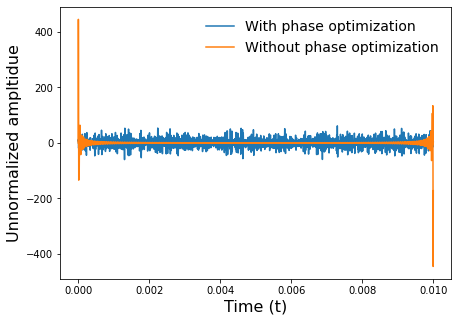

In [7]:
sig = get_signal(tt, ff, best_phase)
bad_sig = get_signal(tt, ff, None)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(tt, sig, label='With phase optimization')
ax.plot(tt, bad_sig, label='Without phase optimization')

ax.set_xlabel('Time (t)', fontsize=16)
ax.set_ylabel('Unnormalized ampltidue', fontsize=16)
ax.legend(frameon=False, fontsize=14)

Now plot the FFT magnitude of the signal - should see a flat band in our frequency range

(15000.0, 75000.0)

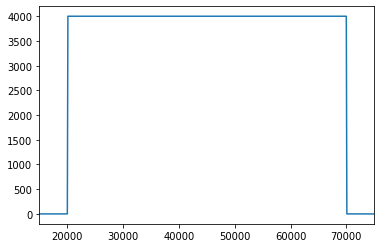

In [8]:
sp = fftshift(fft(sig))
freq = fftshift(fftfreq(tt.size, delta_t))

plt.plot(freq, np.abs(sp))
plt.xlim(fstart-5000, fend + 5000)

Can also estimate the signal PSD - I think ideally we want to repeat the measurement using many different phase configurations and average over them.

(15000.0, 75000.0)

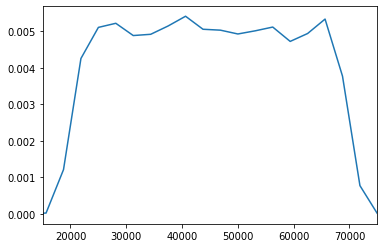

In [9]:
f, pxx = welch(sig, rep_rate*nsample)
plt.plot(f, pxx)

plt.xlim(fstart-5000, fend + 5000)

In [17]:
file_name = 'freq_comb_20khz_70khz.npz'
np.savez(file_name, sig=sig, tt=tt, ff=ff)